
Optionals: 
1. We might need to implement random data at the end of the project.

# Import of Important Library, Network and Meta Data

In [993]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [994]:
# Import Network data
networkData = pd.read_csv('TD3_primary_undirected_temporal.csv')
networkData["time"] //= 8
networkData

,time,node-i,node-j
0,0,58,63
1,0,59,64
2,0,63,66
3,0,85,190
4,0,85,214
...,...,...,...
125768,387,152,172
125769,387,152,174
125770,387,167,180
125771,387,172,178


In [995]:
# Import MetaData [information on the nodes (class, gender)]
metadata = pd.read_csv("TD3_primary_metadata.csv")
metadata

,node-index,class,gender
0,0,5B,M
1,1,5B,F
2,2,5B,M
3,3,5B,F
4,4,5B,M
...,...,...,...
237,237,2A,M
238,238,2A,F
239,239,2A,M
240,240,1B,F


In [996]:
metadata[ metadata['class']=='5B' ]['node-index']

0        0
1        1
2        2
3        3
4        4
5        5
6        6
7        7
8        8
9        9
10      10
11      11
19      19
21      21
22      22
25      25
26      26
28      28
29      29
61      61
67      67
70      70
71      71
150    150
Name: node-index, dtype: int64

# Initialisation of Simulation


1. 1 / alpha : latent period of virus
2. 1 / gamma : mean infectious period
3. beta : contact rate

In [997]:
ALPHA = 1/2 #S -> E
BETA = 0.8 #E -> I 
GAMMA = 1/14 #I -> R 

## Flags of State of Nodes
SUSCEPTIBLE = 1
EXPOSED = 2
INFECTIOUS = 3
RECOVERED = 4

# Simulation

In [998]:
tMax = networkData['time'].max()

numOfNodes = metadata.shape[0]
print("Number of Nodes: ", numOfNodes)

#Initialisation od Status Matrix, where everyone is susceptible
statusMatrix = np.full((tMax+1, numOfNodes), SUSCEPTIBLE)
print(statusMatrix.shape)

Number of Nodes:  242
(388, 242)


In [999]:
NUMOFPATIENTZERO = 1
np.random.seed(0)
patientZerosArray = np.random.randint(0, numOfNodes, size=NUMOFPATIENTZERO)
for patientZero in patientZerosArray:
    statusMatrix[0][patientZero] = EXPOSED

print(statusMatrix[0])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [1000]:
from collections import defaultdict
edgesDictionaryWRTTime = [defaultdict(set) for time in range(0, tMax + 1)]

for time, node_i, node_j in networkData.values:
    edgesDictionaryWRTTime[time][node_i].add(node_j)
    edgesDictionaryWRTTime[time][node_j].add(node_i)
print(edgesDictionaryWRTTime[0])

defaultdict(<class 'set'>, {58: {62, 63}, 63: {58, 66, 62}, 59: {64}, 64: {59}, 66: {62, 63}, 85: {214, 190, 191}, 190: {85}, 214: {85, 191}, 102: {115}, 115: {102}, 191: {85, 214, 199}, 199: {191}, 143: {192}, 192: {143}, 188: {194, 134}, 194: {188, 134}, 62: {58, 66, 63}, 163: {172}, 172: {154, 163, 157}, 184: {186, 196, 198}, 186: {184}, 196: {184}, 36: {50, 51}, 51: {36}, 154: {176, 172, 156, 157}, 156: {154}, 17: {32, 41, 27, 39}, 39: {17}, 80: {87}, 87: {80}, 157: {154, 172}, 13: {32, 41, 16, 23, 27}, 32: {41, 13, 17, 23, 27}, 41: {32, 13, 17, 20, 23, 27}, 20: {41, 15}, 35: {24, 43, 15}, 43: {35}, 50: {36}, 88: {90}, 90: {88}, 152: {168}, 168: {152, 166}, 161: {164}, 164: {161}, 162: {173}, 173: {162}, 166: {168}, 23: {32, 16, 13, 41}, 27: {32, 17, 13, 41}, 15: {35, 20}, 24: {35}, 76: {79}, 79: {76}, 78: {83}, 83: {78}, 134: {194, 188}, 176: {154}, 12: {30, 31}, 30: {18, 12, 31}, 31: {18, 12, 30}, 16: {18, 13, 23}, 18: {16, 30, 31}, 198: {184}})


In [1001]:
rand = lambda proba, numOfNodes: np.random.uniform(0, 1, size=numOfNodes) < proba

# Vaccination Strategies 

This section defines functions that are run for each timestep, and vaccinate susceptible people based on some strategy.
 

### 1. Random vaccination

Randomly vaccinate a proportion of the population to vaccinate on pre-decided time-steps.

In [1002]:
def random_vaccination_strategy(
    curr_timestep, 
    VAX_TIMESTEPS, 
    statusMatrix, 
    proportionToVax
    ): 
    if curr_timestep in VAX_TIMESTEPS: 
        # Vaccinating people in each valid timestep 
        susceptiblePopulation = np.where(statusMatrix[curr_timestep] == SUSCEPTIBLE)[0]
        newlyVaccinated = susceptiblePopulation[rand(proportionToVax, len(susceptiblePopulation))]
        statusMatrix[curr_timestep, newlyVaccinated] = RECOVERED
    return statusMatrix

### 2. Periodic Timestep Vaccination 
 
 Randomly vaccinate a certain amount of the population based on the period given

In [1003]:
def periodic_vaccination_strategy(curr_timestep, PERIOD, statusMatrix, proportionToVax):  
    # We will reuse the random vaccination strat function, 
    # But the effect is the same
    return random_vaccination_strategy(
            curr_timestep, 
            VAX_TIMESTEPS=range(1, tMax, PERIOD), 
            statusMatrix=statusMatrix, 
            proportionToVax=proportionToVax
            )

### 3. Constants doses of Vaccin
Now, we want to know, given a constant number of vaccine doses, if we've better to give all doses on the same time at the beginning of the epidemic discovery or to split it continuously during a certain period of time.

In [1004]:
def periodic_vaccination_strategy(curr_timestep, PERIODBETWEENVAX, NDOSES, statusMatrix, NDOSESUSED):  
    # We will reuse the random vaccination strat function, 
    # But the effect is the same
    return random_vaccination_strategy(
            curr_timestep, 
            VAX_TIMESTEPS=[PERIODBETWEENVAX*k for k in range(NDOSES//NDOSESUSED)], 
            statusMatrix=statusMatrix, 
            proportionToVax=NDOSESUSED/len(statusMatrix[0])
            )

### 4. Stratified Vaccination

Here, we vaccinate a percentage of each class, say 5A or 5B as part of the strategy. For example, we can vaccinate 10% of 5A and 10% of 5B so as to vaccinate 20% of the population as before, but the difference comes in the potential networks that we can have due to the classes.

In [1005]:
def stratified_vaccination_strategy (
    curr_timestep, 
    VAX_TIMESTEPS,
    percentage_per_class, 
    statusMatrix 
    ): 
    
# Here, we need to select `class_percent` of each class, 
# and vaccinate them according to random_vaccination_strategy. 
# We assume that `metadata` from the file `TD3_primary_metadata.csv` 
# is available.
    if curr_timestep not in VAX_TIMESTEPS: 
        # Do nothing if we shouldn't vaclass_percentcinate this round
        return statusMatrix; 
    
    # Else, we vaccinate stratified-ly :)
    for _class, class_percent in percentage_per_class.items(): 
        nodes = metadata[ metadata['class']==_class ]['node-index']
        print( statusMatrix[curr_timestep][nodes])
        statusMatrix[:][nodes] = random_vaccination_strategy(
            curr_timestep, VAX_TIMESTEPS,
            statusMatrix[:][nodes], 
            class_percent
        ); 
    return statusMatrix

In [1006]:
VAX_TIMESTEPS = [100] # For random vaccination strategy
VAX_PERIOD = 7 # For the periodic vaccinations strategy
VAX_STRATIFIED = {'5B': 0.1, '2A': 0.1}; # For the stratified vaccination strategy.
PERIODBETWEENVAX = 7
NDOSES = 50
NDOSESUSED = 10   

for t in range(tMax):
    
    # Now vaccinating at timesteps near you ... 
    # 1. Random strat -
    # statusMatrix = random_vaccination_strategy(t, VAX_TIMESTEPS, statusMatrix, proportionToVax=0.1)
    
    # 2. Periodic strat -  
    # statusMatrix = periodic_vaccination_strategy(t, VAX_PERIOD, statusMatrix, proportionToVax=0.1)
    
    # 3. constant doses of Vaccins
    # statusMatrix = periodic_vaccination_strategy(t, PERIODBETWEENVAX, NDOSES, statusMatrix, NDOSESUSED)

    # 4. Stratified Vaccination Strategy
    statusMatrix = stratified_vaccination_strategy(
        curr_timestep=t, 
        VAX_TIMESTEPS=VAX_TIMESTEPS,
        percentage_per_class=VAX_STRATIFIED, 
        statusMatrix=statusMatrix
    )

    
    statusMatrix[t+1] = statusMatrix[t]
    exposedPopulation = np.where(statusMatrix[t]==EXPOSED)[0]
    newlyInfectious = exposedPopulation[rand(ALPHA,len(exposedPopulation))]
    statusMatrix[t+1, newlyInfectious] = INFECTIOUS

    InfectiousPopulation = np.where(statusMatrix[t]==INFECTIOUS)[0]
    riskContact = np.array([node_j for node_i in InfectiousPopulation for node_j in edgesDictionaryWRTTime[t][node_i] if statusMatrix[t,node_j]==SUSCEPTIBLE], dtype=int)
    newlyExposed = riskContact[rand(BETA, len(riskContact))]
    statusMatrix[t+1, newlyExposed] = EXPOSED
    
    newlyRecovered = InfectiousPopulation[rand(GAMMA, len(InfectiousPopulation))]
    statusMatrix[t+1, newlyRecovered] = RECOVERED

    
print(np.where(statusMatrix[tMax]==RECOVERED)[0])

<generator object stratified_vaccination_strategy.<locals>.<genexpr> at 0x000002A681E733E0>
[4 1 3 4 1 4 4 1 4 3 1 4 1 4 1 3 3 1 3 4 4 4 1 1]


IndexError: index 100 is out of bounds for axis 0 with size 24

In [ ]:
# Plotting the growth of S, E, I and R populations
listPopulations = [] # List of dicts, indexed by timestep #np.zeros(shape=(tMax))
print(statusMatrix[1])
for timestep in range(tMax):
    temp = np.unique(statusMatrix[timestep], return_counts=True)
    # print(temp)
    listPopulations.append( dict(zip(temp[0], temp[1])) )

listPopulations = pd.DataFrame.from_dict(listPopulations).fillna(0).astype(int)
listPopulations.sort_index(axis=1, inplace=True)
print(listPopulations)
# Do this at your own risk.
# print(listPopulations)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
       1  2  3    4
0    241  1  0    0
1    241  1  0    0
2    241  1  0    0
3    241  1  0    0
4    241  1  0    0
..   ... .. ..  ...
382   37  0  0  205
383   37  0  0  205
384   37  0  0  205
385   37  0  0  205
386   37  0  0  205

[387 rows x 4 columns]


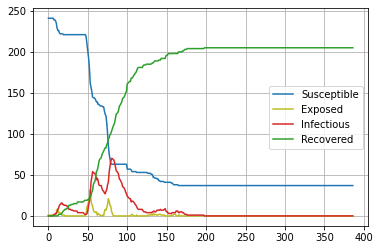

In [ ]:
# Now we're plotting things
listPopulations.rename(columns={1 : "Susceptible", 2: "Exposed", 3: "Infectious", 4: "Recovered"}, inplace=True)
listPopulations.plot(color=['tab:blue','tab:olive','tab:red','tab:green'])
plt.legend()
plt.grid()
plt.savefig('listPopulations.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


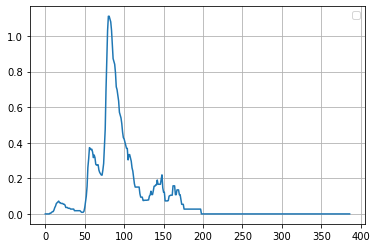

In [ ]:
plt.plot (listPopulations['Infectious']/listPopulations['Susceptible'])
plt.legend()
plt.grid()

In [ ]:
## A function that returns the end of pandemic if it ends before end of data or -1 otherwise
def endOfEpidemic(dfListPopulations):
    endDay = 0
    for row in dfListPopulations.values:
        if row[EXPOSED-1] !=0 or row[INFECTIOUS-1] != 0:
            endDay += 1
        else:
            break
    if endDay == listPopulations.shape[0]:
        return -1
    else:
        return endDay

print("End of Epidemic : ", endOfEpidemic(listPopulations))

End of Epidemic :  198


In [ ]:
# STATEDICT ={1 : "Susceptible", 2: "Exposed", 3: "Infectious", 4: "Recovered"}

TIME = 0
def networkGraphAtTimet(networkData, statusMatrix, time):
    query =  "time=={time}".format(time = time)
    numOfNodes = statusMatrix.shape[1]
    graph = ig.Graph(n=numOfNodes, edges=networkData.query(query)[['node-i','node-j']].values)
    graph.vs["state"] = statusMatrix[time]
    color_dict = {1: "lightblue", 2: "yellow", 3:"red", 4:"green"}
    graph.vs["color"] = [color_dict[state] for state in graph.vs["state"]]
    graph.vs["label"] = [node for node in range(numOfNodes)]
    graph.simplify(multiple=True)
    return graph

# Sequential plotting for animation
TMAX = 220
TSTEP = 1
for t in range(0, TMAX, TSTEP):
    img = ig.plot(networkGraphAtTimet(networkData, statusMatrix, t), vertex_label_color="black", vertex_label_size=8, vertex_size=14)
    img.save("img/" + str(t) + ".png")